In [1]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
import re
import pandas as pd
from datasets import Dataset, ClassLabel
from sklearn.model_selection import train_test_split
# import logging
# logging.disable(logging.WARNING)

2024-07-21 07:26:05.558633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 07:26:05.558743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 07:26:05.858424: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Setting up datasets

In [2]:
# data = pd.read_csv("dataset_bmm.csv")
data = pd.read_csv("/kaggle/input/bmm-dataset/dataset_bmm.csv")

X_y = pd.DataFrame(
    {
        "prompt": data["prompt"].apply(lambda x: x[22:-24]).apply(lambda x: re.sub(' +', ' ', x).strip()) 
        + ' ' + 
        data["model_response"].fillna('').apply(lambda x: re.sub(' +', ' ', x).strip()),
        "target": data["target"].astype(int).astype("category")
    }
)
X_y

,prompt,target
0,// Copyright 2020 The Go Authors. All rights r...,0
1,import re\nimport uuid\nimport orjson\nimport ...,0
2,"package tlsrpt\nimport (\n\t""fmt""\n\t""net/url""...",0
3,"import { describe, expect, test } from '@jest/...",0
4,"import type {\n DefaultError,\n Enabled,\n Fet...",0
...,...,...
6657,"import { describe, expectTypeOf } from 'vitest...",1
6658,import moment from'moment';\nimport type { Mom...,1
6659,"package dkim\nimport (\n\t""encoding/base64""\n\...",0
6660,package com.tencent.supersonic.headless.chat.k...,0


In [3]:
X_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6662 entries, 0 to 6661
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   prompt  6662 non-null   object  
 1   target  6662 non-null   category
dtypes: category(1), object(1)
memory usage: 58.8+ KB


In [4]:
dataset = Dataset.from_dict(
    mapping={
        "prompt": X_y["prompt"].tolist(),
        "labels": X_y["target"].tolist(),
    }
)
dataset

Dataset({
    features: ['prompt', 'labels'],
    num_rows: 6662
})

In [5]:
dataset["prompt"][0]

'// Copyright 2020 The Go Authors. All rights reserved.\n// Use of this source code is governed by a BSD-style\n// license that can be found in the LICENSE file.\npackage order\nimport (\n\t"google.golang.org/protobuf/reflect/protoreflect"\n)\n// FieldOrder specifies the ordering to visit message fields.\n// It is a function that reports whether x is ordered before y.\ntype FieldOrder func(x, y protoreflect.FieldDescriptor) bool\nvar (\n\t// AnyFieldOrder specifies no specific field ordering.\n\tAnyFieldOrder FieldOrder = nil\n\t// LegacyFieldOrder sorts fields in the same ordering as emitted by\n\t// wire serialization in the github.com/golang/protobuf implementation.\n\tLegacyFieldOrder FieldOrder = func(x, y protoreflect.FieldDescriptor) bool {\n\t\tox, oy := x.ContainingOneof(), y.ContainingOneof()\n\t\tinOneof := func(od protoreflect.OneofDescriptor) bool {\n\t\t\treturn od!= nil &&!od.IsSynthetic()\n\t\t}\n\t\t// Extension fields sort before non-extension fields.\n\t\tif x.IsExte

In [6]:
dataset = dataset.cast_column('labels', ClassLabel(names=['0', '1']))
# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("mrm8488/codebert-base-finetuned-detect-insecure-code")

def preprocess_function(examples):
    tokens = tokenizer(examples['prompt'], truncation=False, padding=False)
    input_ids = tokens['input_ids']
    
    num_tokens_from_each_end = 256
    
    # Получение токенов с начала и с конца
    beginning_tokens = [ids[:num_tokens_from_each_end] for ids in input_ids]
    end_tokens = [ids[-num_tokens_from_each_end:] for ids in input_ids]
    
    # Объединение токенов
    combined_tokens = [b + e for b, e in zip(beginning_tokens, end_tokens)]
    
    # Применение паддинга до длины 512 токенов
    combined_tokens = [
        ids + [tokenizer.pad_token_id] * (512 - len(ids)) if len(ids) < 512 else ids[:512]
        for ids in combined_tokens
    ]
    
    attention_mask = [[1] * len(ids) for ids in combined_tokens]
    
    return {'input_ids': combined_tokens, 'attention_mask': attention_mask}

# Применение функции токенизации
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Casting the dataset:   0%|          | 0/6662 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Map:   0%|          | 0/6662 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (864 > 512). Running this sequence through the model will result in indexing errors


In [7]:
# Разделение данных на обучающую и тестовую выборки
split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42, stratify_by_column='labels')
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

In [8]:
train_dataset

Dataset({
    features: ['prompt', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 5329
})

In [9]:
test_dataset

Dataset({
    features: ['prompt', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 1333
})

In [10]:
tokenizer(dataset["prompt"][0])['input_ids'][:5]

[0, 42326, 1894, 2760, 20]

In [11]:
tokenizer("import describe, expect, test { ")

{'input_ids': [0, 41975, 6190, 6, 1057, 6, 1296, 25522, 1437, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

# Training

In [12]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
)

In [13]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=1000,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
#     weight_decay=1e-6,
#     learning_rate=5e-5,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_fbeta",
)


# Load the model
model = RobertaForSequenceClassification.from_pretrained(
    "mrm8488/codebert-base-finetuned-detect-insecure-code", num_labels=2
)


# Define a compute_metrics function
def compute_metrics(p):
    # Find the index of the maximum value along the last axis
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    precision = precision_score(labels, preds, average="binary")
    recall = recall_score(labels, preds, average="binary")
    f1 = f1_score(labels, preds, average="binary")
    fbeta = fbeta_score(labels, preds, beta=1.25, average="binary")
    accuracy = accuracy_score(labels, preds)
    roc_auc = roc_auc_score(labels, preds)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "fbeta": fbeta,
        "roc_auc": roc_auc,
    }


# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [14]:
# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Fbeta,Roc Auc
1,0.672100,0.651263,0.615904,0.540541,0.115163,0.189873,0.166205,0.526178
2,0.632500,0.661964,0.606902,0.497373,0.545106,0.520147,0.525428,0.595829
3,0.627500,0.631440,0.655664,0.582888,0.418426,0.487151,0.470198,0.613154
4,0.472600,0.667075,0.652663,0.543675,0.692898,0.609283,0.625862,0.659873
5,0.380900,0.801200,0.663166,0.554878,0.698656,0.618522,0.634497,0.669525
6,0.204200,1.087254,0.684171,0.598039,0.585413,0.591659,0.590276,0.666475
7,0.182900,1.753674,0.682671,0.578275,0.694818,0.631212,0.644156,0.684847
8,0.055700,2.078702,0.709677,0.641949,0.581574,0.610272,0.603732,0.686723
9,0.011400,2.249536,0.707427,0.630219,0.608445,0.619141,0.616761,0.689691
10,0.000300,2.327520,0.696924,0.610169,0.621881,0.615970,0.617258,0.683477


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

{'eval_loss': 1.7536736726760864, 'eval_accuracy': 0.6826706676669168, 'eval_precision': 0.5782747603833865, 'eval_recall': 0.6948176583493282, 'eval_f1': 0.6312118570183085, 'eval_fbeta': 0.644156069615034, 'eval_roc_auc': 0.6848472528199842, 'eval_runtime': 26.914, 'eval_samples_per_second': 49.528, 'eval_steps_per_second': 3.121, 'epoch': 10.0}


ValueError: x and y must have same first dimension, but have shapes (334,) and (11,)

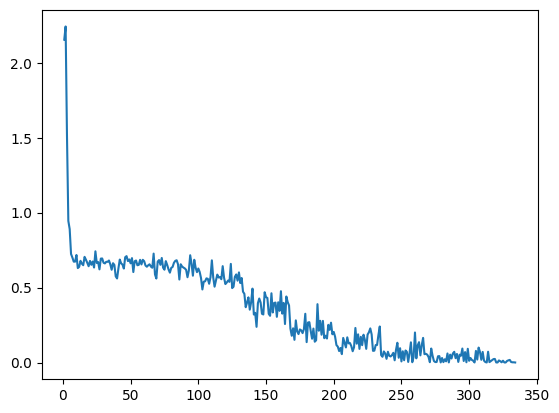

In [15]:
import matplotlib.pyplot as plt
history = trainer.state.log_history

train_loss = [x['loss'] for x in history if 'loss' in x]
eval_fbeta = [x['eval_fbeta'] for x in history if 'eval_fbeta' in x]
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, eval_fbeta, label='Validation F-beta Score (beta=1.25)')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Learning Curves')
plt.show()

In [16]:
%%time
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
logits

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


CPU times: user 27.9 s, sys: 266 ms, total: 28.2 s
Wall time: 27.3 s


array([[-0.37488258,  0.5346579 ],
       [ 4.2682114 , -3.783501  ],
       [-3.0133069 ,  2.8443909 ],
       ...,
       [ 4.4403086 , -3.8243697 ],
       [ 4.3581557 , -3.7332397 ],
       [ 4.4385877 , -3.906484  ]], dtype=float32)

In [17]:
import torch
probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
probabilities

array([[2.8709388e-01, 7.1290612e-01],
       [9.9968159e-01, 3.1845464e-04],
       [2.8496725e-03, 9.9715036e-01],
       ...,
       [9.9974257e-01, 2.5738555e-04],
       [9.9969399e-01, 3.0606857e-04],
       [9.9976248e-01, 2.3750798e-04]], dtype=float32)

In [18]:
threshold = 0.5
y_pred = (probabilities[:, 1] >= threshold).astype(int)

# Оценка производительности модели
y_test = test_dataset["labels"]

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    fbeta_score,
    precision_score,
    roc_auc_score,
    make_scorer,
)

def get_scores(y_true, y_pred) -> pd.Series:
    return pd.Series(
        np.array(
            [
                accuracy_score(y_true, y_pred),
                recall_score(y_true, y_pred),
                f1_score(y_true, y_pred),
                precision_score(y_true, y_pred),
                fbeta_score(y_true, y_pred, beta=1.25),
                roc_auc_score(y_true, y_pred),
            ]
        ),
        index=["Accuracy", "Recall", "F1", "Precision", "F_beta", "ROC_AUC"],
    )
get_scores(y_test, y_pred)

Accuracy     0.682671
Recall       0.694818
F1           0.631212
Precision    0.578275
F_beta       0.644156
ROC_AUC      0.684847
dtype: float64

на всей выборке

In [20]:
%%time
predictions = trainer.predict(tokenized_dataset)
logits = predictions.predictions
probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


CPU times: user 2min 16s, sys: 1.44 s, total: 2min 17s
Wall time: 2min 13s


In [21]:
threshold = 0.5
y_pred = (probabilities[:, 1] >= threshold).astype(int)

In [23]:
# Оценка производительности модели
y = tokenized_dataset["labels"]
get_scores(y, y_pred)

Accuracy     0.927499
Recall       0.933154
F1           0.909567
Precision    0.887144
F_beta       0.914642
ROC_AUC      0.928513
dtype: float64